Data loaded and prepared successfully.
Tasks to analyze: ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6']
Metrics to analyze: ['TimeOnTask_s', 'Clicks', 'PathLength']
Sites: ['smallpdf' 'ilovepdf']
Total valid trials: 120

--- Analyzing Task: Task1 ---
ilovepdf participants: 10
smallpdf participants: 10

Metric: TimeOnTask_s
 ilovepdf: Mean=86.53, Median=87.55, StdDev=47.32, N=10
 smallpdf: Mean=86.48, Median=89.53, StdDev=31.34, N=10
 Mann-Whitney U Test: U=45.00, p=0.7337
  Result: No statistically significant difference (p >= 0.05)

Metric: Clicks
 ilovepdf: Mean=24.60, Median=24.00, StdDev=9.66, N=10
 smallpdf: Mean=20.00, Median=20.50, StdDev=6.72, N=10
 Mann-Whitney U Test: U=64.50, p=0.2897
  Result: No statistically significant difference (p >= 0.05)

Metric: PathLength
 ilovepdf: Mean=29596.58, Median=26075.08, StdDev=9762.72, N=10
 smallpdf: Mean=24626.85, Median=24490.20, StdDev=7680.70, N=10
 Mann-Whitney U Test: U=63.00, p=0.3447
  Result: No statistically significan

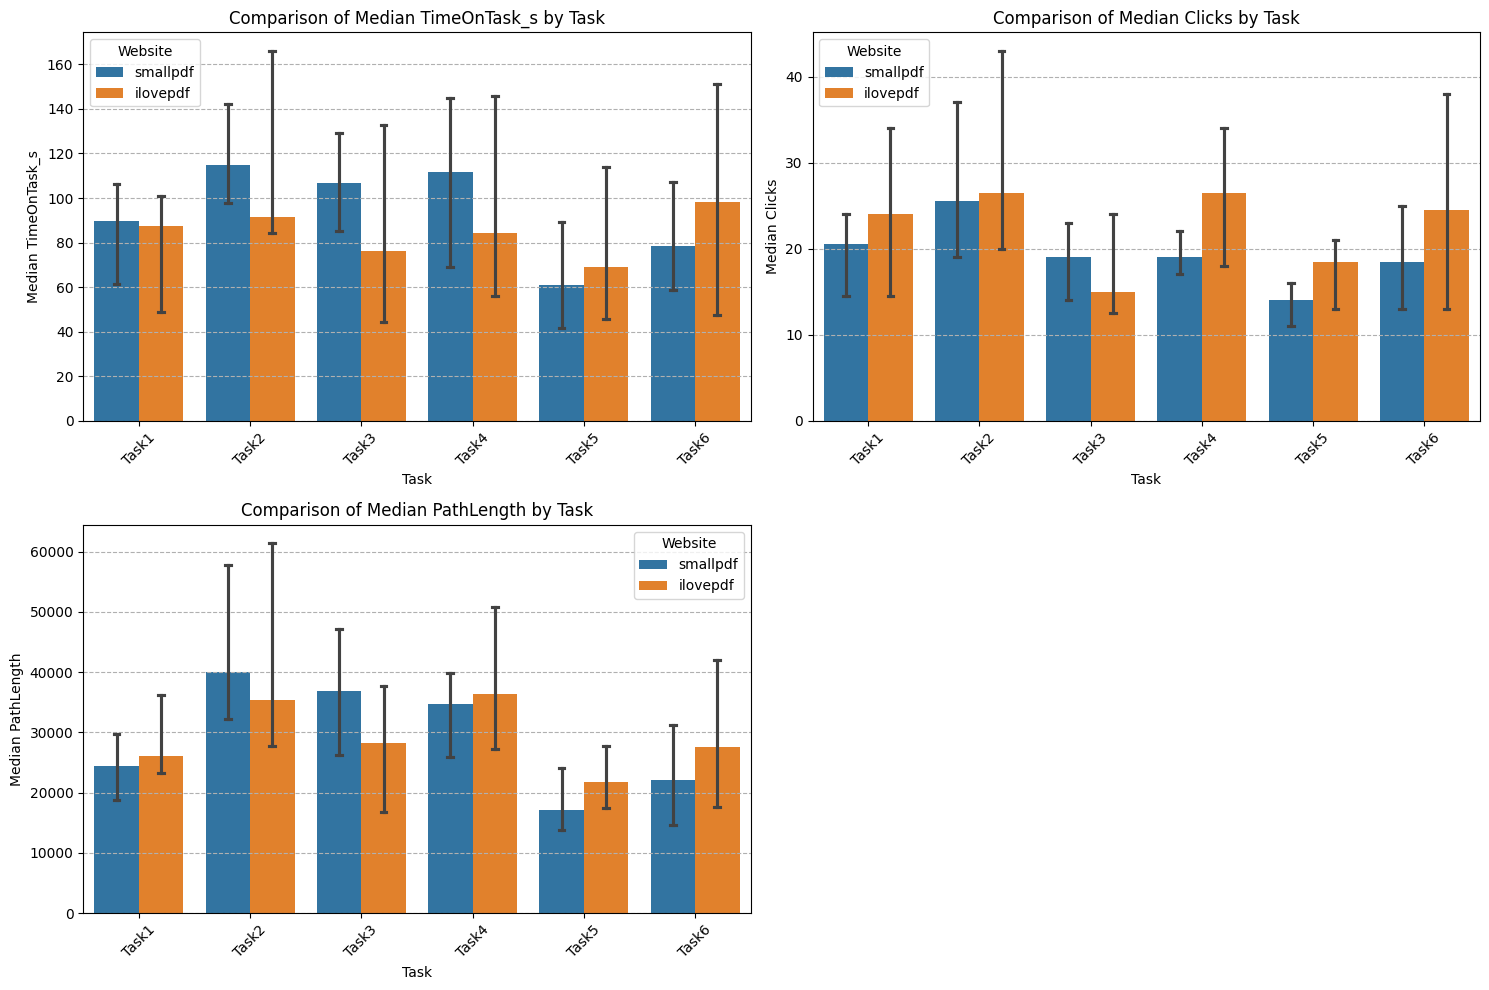


--- Analysis Complete ---


In [3]:
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load and Prepare Data ---
# Load the CSV file (replace with your actual file path)
try:
    # Assuming the file is in the same directory as the script
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names (remove spaces, special characters)
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)

    # Convert Time to Seconds
    df["TimeOnTask_s"] = df["TrialDurationms"] / 1000

    # Rename columns for easier access
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MousePathlengthpx": "PathLength",
            "TrialName": "Task",
        },
        inplace=True,
    )

    # Map Site codes to names (assuming 's' is smallpdf, 'i' is ilovepdf)
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # Define metrics to analyze
    metrics = ["TimeOnTask_s", "Clicks", "PathLength"]
    tasks = sorted(df_filtered["Task"].unique())

    print("Data loaded and prepared successfully.")
    print(f"Tasks to analyze: {tasks}")
    print(f"Metrics to analyze: {metrics}")
    print(f"Sites: {df_filtered['SiteName'].unique()}")
    print(f"Total valid trials: {len(df_filtered)}")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Statistical Analysis ---
results = {}

for task in tasks:
    results[task] = {}
    df_task = df_filtered[df_filtered["Task"] == task]
    site1_data = df_task[df_task["SiteName"] == "ilovepdf"]
    site2_data = df_task[df_task["SiteName"] == "smallpdf"]

    print(f"\n--- Analyzing Task: {task} ---")
    print(f"ilovepdf participants: {len(site1_data)}")
    print(f"smallpdf participants: {len(site2_data)}")

    if len(site1_data) == 0 or len(site2_data) == 0:
        print("Skipping task due to missing data for one or both sites.")
        continue

    for metric in metrics:
        results[task][metric] = {}

        data1 = site1_data[metric].dropna()
        data2 = site2_data[metric].dropna()

        # Descriptive Statistics
        desc1 = data1.describe()
        desc2 = data2.describe()
        median1 = data1.median()
        median2 = data2.median()

        results[task][metric]["desc_ilovepdf"] = desc1
        results[task][metric]["median_ilovepdf"] = median1
        results[task][metric]["desc_smallpdf"] = desc2
        results[task][metric]["median_smallpdf"] = median2

        print(f"\nMetric: {metric}")
        print(
            f" ilovepdf: Mean={desc1['mean']:.2f}, Median={median1:.2f}, StdDev={desc1['std']:.2f}, N={int(desc1['count'])}"
        )
        print(
            f" smallpdf: Mean={desc2['mean']:.2f}, Median={median2:.2f}, StdDev={desc2['std']:.2f}, N={int(desc2['count'])}"
        )

        # Check if data exists for statistical test
        if len(data1) < 1 or len(data2) < 1:
            print(" Not enough data for statistical test.")
            results[task][metric]["stat_test"] = "Not enough data"
            continue

        # Inferential Statistics (Mann-Whitney U test recommended for small N)
        try:
            stat, p_value = mannwhitneyu(data1, data2, alternative="two-sided")
            results[task][metric]["stat_test"] = "Mann-Whitney U"
            results[task][metric]["statistic"] = stat
            results[task][metric]["p_value"] = p_value
            print(f" Mann-Whitney U Test: U={stat:.2f}, p={p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
                # Determine which site has higher median (generally harder)
                if median1 > median2:
                    print(
                        "  Interpretation: ilovepdf has significantly higher median value."
                    )
                elif median2 > median1:
                    print(
                        "  Interpretation: smallpdf has significantly higher median value."
                    )
                else:
                    print(
                        "  Interpretation: Medians are equal, but distribution differs significantly."
                    )
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")

        except ValueError as ve:
            # Handle cases like identical data which might cause issues
            print(f" Could not perform Mann-Whitney U test: {ve}")
            results[task][metric]["stat_test"] = f"Mann-Whitney U Error: {ve}"
            # Optional: Try t-test as fallback or if assumptions met
            # try:
            #     stat_t, p_value_t = ttest_ind(data1, data2, equal_var=False) # Welch's t-test
            #     results[task][metric]['stat_test'] = 'Welch t-test'
            #     results[task][metric]['statistic'] = stat_t
            #     results[task][metric]['p_value'] = p_value_t
            #     print(f" Welch's t-test: t={stat_t:.2f}, p={p_value_t:.4f}")
            # except Exception as te:
            #     print(f" Could not perform t-test: {te}")


# --- 3. Visualization ---
n_metrics = len(metrics)
n_cols = 2  # Adjust layout as needed
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
axes_flat = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes_flat[i]
    plot_data = df_filtered.dropna(subset=[metric])  # Drop NaN for the specific metric

    # Use median for plotting center point due to small N and potential skewness
    # Use error bars representing Interquartile Range (IQR) or Std Dev as indicator of spread
    sns.barplot(
        data=plot_data,
        x="Task",
        y=metric,
        hue="SiteName",
        estimator=np.median,
        errorbar=("ci", 95),  # Shows 95% CI based on bootstrapping for median
        # estimator=np.mean, errorbar='sd', # Alternative: Use mean and std dev
        capsize=0.1,
        ax=ax,
        order=tasks,
    )  # Ensure tasks are ordered

    ax.set_title(f"Comparison of Median {metric} by Task")
    ax.set_ylabel(f"Median {metric}")
    ax.set_xlabel("Task")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Website")
    ax.grid(axis="y", linestyle="--")

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")
# You can access detailed results from the 'results' dictionary
# Example: print(results['Task1']['TimeOnTask_s'])


Data loaded. N = 20 participants.
Tasks to analyze: ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6']
Metrics to analyze: ['TimeOnTask_s', 'Clicks', 'PathLength']

Paired data structure created. Rows: 120

--- Analyzing Task: Task1 ---
Participants in this task: 20

Metric: TimeOnTask_s
 ilovepdf: Mean=nan, Median=nan, StdDev=nan, N=0
 smallpdf: Mean=nan, Median=nan, StdDev=nan, N=0
 Not enough paired data (N=0) for statistical test.

Metric: Clicks
 ilovepdf: Mean=nan, Median=nan, StdDev=nan, N=0
 smallpdf: Mean=nan, Median=nan, StdDev=nan, N=0
 Not enough paired data (N=0) for statistical test.

Metric: PathLength
 ilovepdf: Mean=nan, Median=nan, StdDev=nan, N=0
 smallpdf: Mean=nan, Median=nan, StdDev=nan, N=0
 Not enough paired data (N=0) for statistical test.

--- Analyzing Task: Task2 ---
Participants in this task: 20

Metric: TimeOnTask_s
 ilovepdf: Mean=nan, Median=nan, StdDev=nan, N=0
 smallpdf: Mean=nan, Median=nan, StdDev=nan, N=0
 Not enough paired data (N=0) for statis

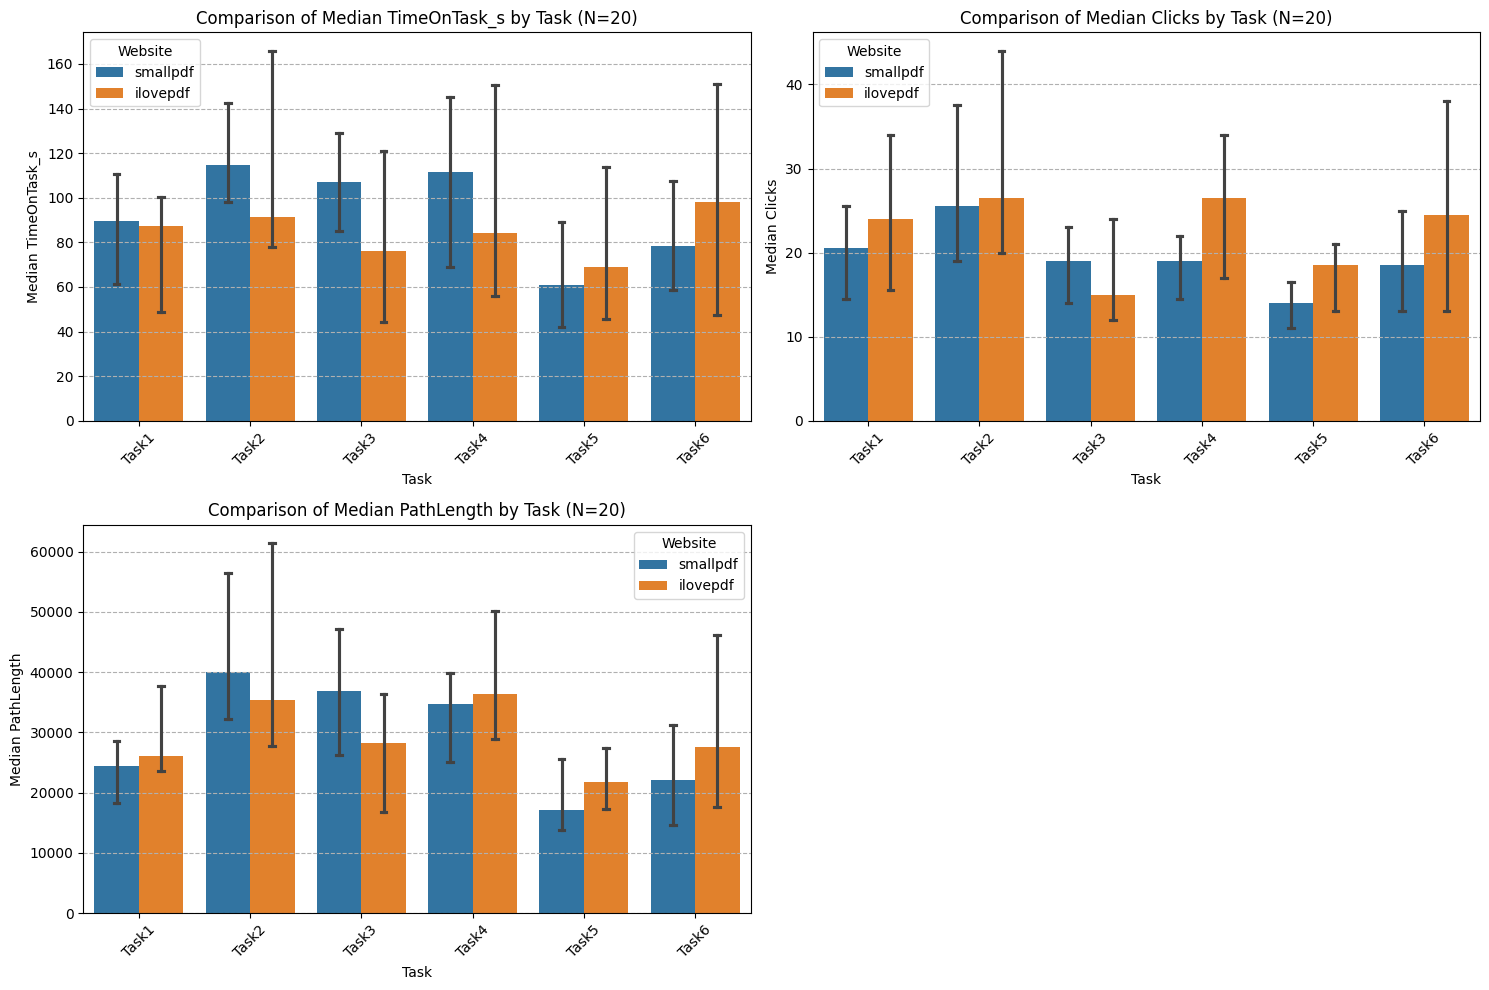


--- Analysis Complete ---


In [4]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel  # Import tests for paired data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load and Prepare Data ---
try:
    # Assuming the file is in the same directory as the script
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)

    # Convert Time to Seconds
    df["TimeOnTask_s"] = df["TrialDurationms"] / 1000

    # Rename columns
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MousePathlengthpx": "PathLength",
            "TrialName": "Task",
        },
        inplace=True,
    )

    # Map Site codes to names
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # Define metrics and tasks
    metrics = ["TimeOnTask_s", "Clicks", "PathLength"]
    tasks = sorted(df_filtered["Task"].unique())
    subjects = df_filtered["SubjectId"].unique()
    N = len(subjects)

    print(f"Data loaded. N = {N} participants.")
    print(f"Tasks to analyze: {tasks}")
    print(f"Metrics to analyze: {metrics}")

    # --- Pivot data for paired analysis ---
    # We need to structure data so each row represents a subject-task,
    # with columns for ilovepdf and smallpdf metrics.
    paired_data = df_filtered.pivot_table(
        index=["SubjectId", "Task"], columns="SiteName", values=metrics
    )
    # Flatten MultiIndex columns (e.g., ('TimeOnTask_s', 'ilovepdf') -> 'TimeOnTask_s_ilovepdf')
    paired_data.columns = ["_".join(col).strip() for col in paired_data.columns.values]
    paired_data.reset_index(inplace=True)

    print(f"\nPaired data structure created. Rows: {len(paired_data)}")
    # print(paired_data.head()) # Optional: check structure

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Statistical Analysis (Paired) ---
results = {}

for task in tasks:
    results[task] = {}
    task_data = paired_data[paired_data["Task"] == task].copy()

    print(f"\n--- Analyzing Task: {task} ---")
    print(f"Participants in this task: {len(task_data)}")

    if len(task_data) == 0:
        print("Skipping task due to no paired data.")
        continue

    for metric in metrics:
        col1 = f"{metric}_ilovepdf"
        col2 = f"{metric}_smallpdf"
        results[task][metric] = {}

        # Check if both columns exist for the metric
        if col1 not in task_data.columns or col2 not in task_data.columns:
            print(f" Skipping metric {metric}: Columns not found in pivoted data.")
            results[task][metric]["error"] = "Columns not found"
            continue

        # Extract paired data, dropping rows where either site is NaN for this metric/task
        data1 = task_data[col1].dropna()
        data2 = task_data[col2].dropna()
        # Align data based on index before dropping NaNs pair-wise
        aligned_data = task_data[[col1, col2]].dropna()
        data1_paired = aligned_data[col1]
        data2_paired = aligned_data[col2]

        # Descriptive Statistics (for the paired samples)
        desc1 = data1_paired.describe()
        desc2 = data2_paired.describe()
        median1 = data1_paired.median()
        median2 = data2_paired.median()

        results[task][metric]["desc_ilovepdf"] = desc1
        results[task][metric]["median_ilovepdf"] = median1
        results[task][metric]["desc_smallpdf"] = desc2
        results[task][metric]["median_smallpdf"] = median2

        print(f"\nMetric: {metric}")
        print(
            f" ilovepdf: Mean={desc1['mean']:.2f}, Median={median1:.2f}, StdDev={desc1['std']:.2f}, N={int(desc1['count'])}"
        )
        print(
            f" smallpdf: Mean={desc2['mean']:.2f}, Median={median2:.2f}, StdDev={desc2['std']:.2f}, N={int(desc2['count'])}"
        )

        # Check if enough paired data exists for statistical test
        if len(data1_paired) < 5:  # Need a minimum number for Wilcoxon
            print(
                f" Not enough paired data (N={len(data1_paired)}) for statistical test."
            )
            results[task][metric]["stat_test"] = "Not enough paired data"
            continue

        # Inferential Statistics (Wilcoxon Signed-Rank test for paired data)
        try:
            # Calculate differences for Wilcoxon
            diff = data1_paired - data2_paired
            # Perform test only if there are non-zero differences
            if np.all(diff == 0):
                print(" All differences are zero. Cannot perform Wilcoxon test.")
                results[task][metric]["stat_test"] = (
                    "Wilcoxon Error: All differences zero"
                )
                continue

            stat, p_value = wilcoxon(
                diff
            )  # Test if difference distribution is centered at zero
            results[task][metric]["stat_test"] = "Wilcoxon Signed-Rank"
            results[task][metric]["statistic"] = stat
            results[task][metric]["p_value"] = p_value
            print(f" Wilcoxon Signed-Rank Test: W={stat:.2f}, p={p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
                # Determine which site has higher median (generally harder)
                if median1 > median2:
                    print(
                        "  Interpretation: ilovepdf has significantly higher median value."
                    )
                elif median2 > median1:
                    print(
                        "  Interpretation: smallpdf has significantly higher median value."
                    )
                else:
                    # If medians are equal but p < 0.05, the distributions differ significantly
                    print(
                        "  Interpretation: Medians are equal, but distribution differs significantly."
                    )
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")

        except ValueError as ve:
            print(f" Could not perform Wilcoxon test: {ve}")
            results[task][metric]["stat_test"] = f"Wilcoxon Error: {ve}"
            # Optional: Try Paired t-test if assumptions seem reasonable
            # try:
            #     stat_t, p_value_t = ttest_rel(data1_paired, data2_paired)
            #     results[task][metric]['stat_test'] = 'Paired t-test'
            #     results[task][metric]['statistic'] = stat_t
            #     results[task][metric]['p_value'] = p_value_t
            #     print(f" Paired t-test: t={stat_t:.2f}, p={p_value_t:.4f}")
            # except Exception as te:
            #     print(f" Could not perform Paired t-test: {te}")


# --- 3. Visualization (Using original long-format data for plotting) ---
n_metrics = len(metrics)
n_cols = 2  # Adjust layout
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
axes_flat = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes_flat[i]
    plot_data = df_filtered.dropna(subset=[metric])

    # Bar plot showing median values for comparison
    sns.barplot(
        data=plot_data,
        x="Task",
        y=metric,
        hue="SiteName",
        estimator=np.median,
        errorbar=("ci", 95),  # 95% CI for median via bootstrap
        capsize=0.1,
        ax=ax,
        order=tasks,
    )

    ax.set_title(f"Comparison of Median {metric} by Task (N={N})")
    ax.set_ylabel(f"Median {metric}")
    ax.set_xlabel("Task")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Website")
    ax.grid(axis="y", linestyle="--")

    # Optional: Add significance indicators if needed based on results dictionary
    # (This requires more complex logic to check p-values and place markers)

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")
# Example: print(results['Task1']['TimeOnTask_s'])


Data loaded. N = 20 participants identified: ['s0401', 's0402', 's0501', 's0502', 's0601', 's0602', 's0701', 's0702', 's0801', 's0802', 's1001', 's1002', 's1101', 's1102', 's1201', 's1202', 's1301', 's1302', 's1401', 's1402']
Tasks to analyze: ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6']
Metrics to analyze: ['TimeOnTask_s', 'Clicks', 'PathLength']

Sample data before pairing:
  SubjectId   Task  SiteName  TimeOnTask_s
1     s0401  Task1  smallpdf          64.0
2     s0401  Task2  smallpdf         142.4
3     s0401  Task3  smallpdf         127.1
4     s0401  Task4  smallpdf         110.8
5     s0401  Task5  smallpdf         113.6

Value counts for SiteName:
SiteName
smallpdf    60
ilovepdf    60
Name: count, dtype: int64

--- Analyzing Task: Task1 ---

Metric: TimeOnTask_s
 Found valid paired data for N = 0 participants in this task/metric.
 No valid paired data found.

Metric: Clicks
 Found valid paired data for N = 0 participants in this task/metric.
 No valid paired data fo

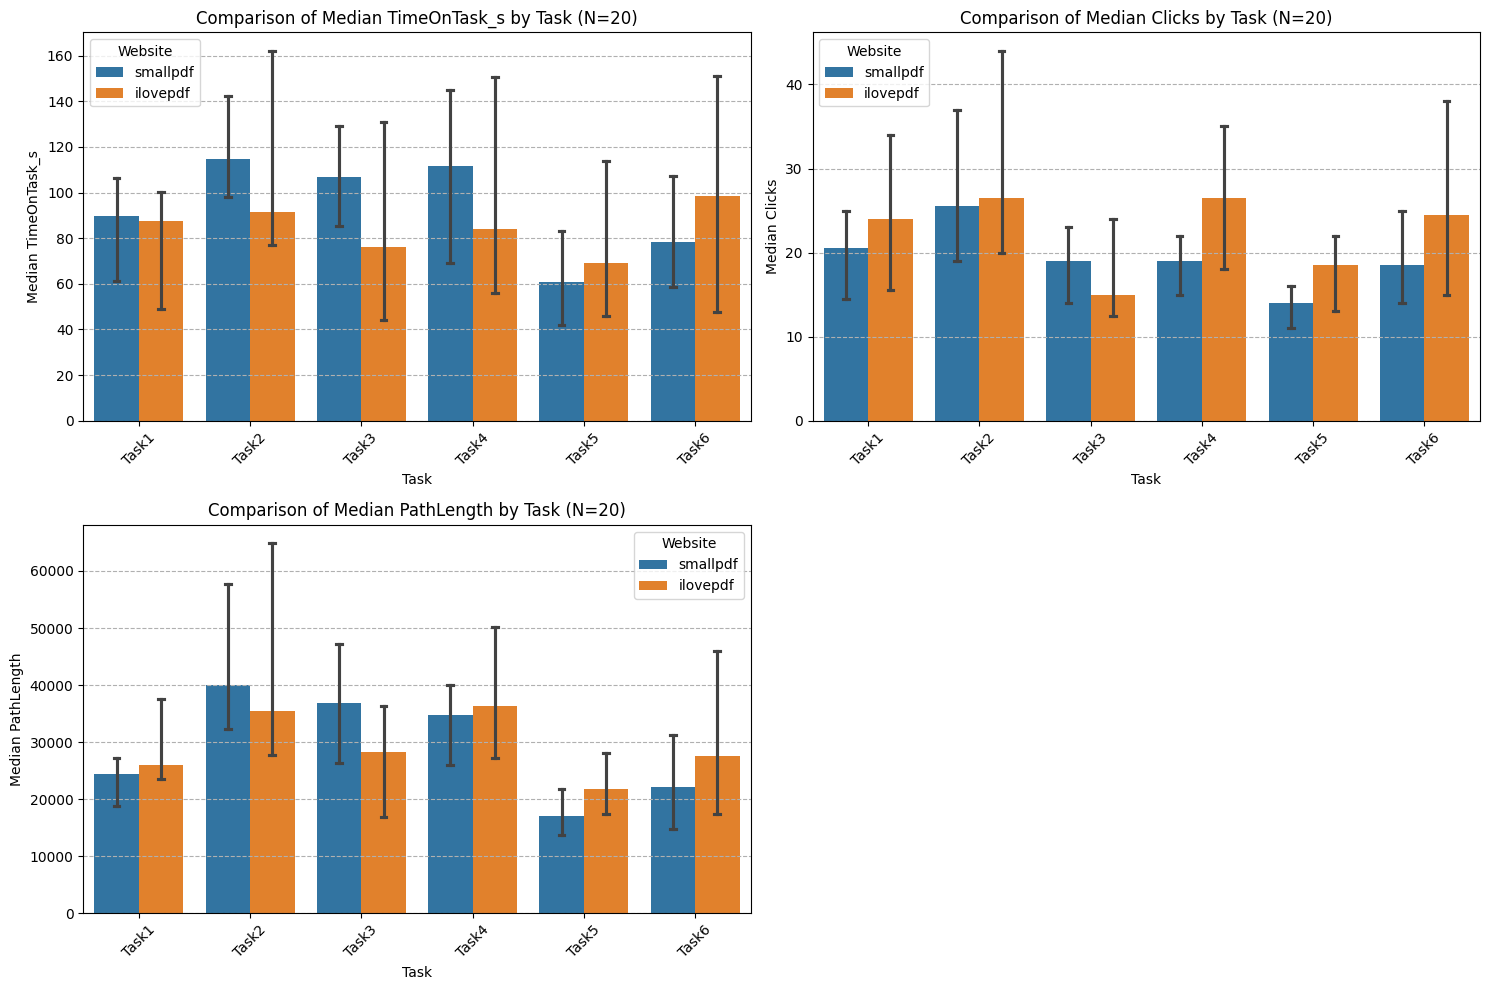


--- Analysis Complete ---


In [5]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load and Prepare Data ---
try:
    # Assuming the file is in the same directory as the script
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)

    # Convert Time to Seconds
    df["TimeOnTask_s"] = df["TrialDurationms"] / 1000

    # Rename columns
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MousePathlengthpx": "PathLength",
            "TrialName": "Task",
        },
        inplace=True,
    )

    # Map Site codes to names
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # Define metrics and tasks
    metrics = ["TimeOnTask_s", "Clicks", "PathLength"]
    tasks = sorted(df_filtered["Task"].unique())
    subjects = sorted(df_filtered["SubjectId"].unique())  # Get unique subjects
    N = len(subjects)

    print(f"Data loaded. N = {N} participants identified: {subjects}")
    print(f"Tasks to analyze: {tasks}")
    print(f"Metrics to analyze: {metrics}")

    # Verify data structure before pairing attempt
    print("\nSample data before pairing:")
    print(df_filtered[["SubjectId", "Task", "SiteName", "TimeOnTask_s"]].head())
    print(f"\nValue counts for SiteName:\n{df_filtered['SiteName'].value_counts()}")


except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Statistical Analysis (Paired - Manual Pairing) ---
results = {}
paired_analysis_data = []  # To store data used in analysis

for task in tasks:
    results[task] = {}
    print(f"\n--- Analyzing Task: {task} ---")

    for metric in metrics:
        results[task][metric] = {}
        list1_ilovepdf = []
        list2_smallpdf = []
        valid_subjects_in_task_metric = 0

        for subject in subjects:
            # Get data for this subject and task
            subject_task_data = df_filtered[
                (df_filtered["SubjectId"] == subject) & (df_filtered["Task"] == task)
            ]

            # Find the value for ilovepdf and smallpdf
            val1 = subject_task_data.loc[
                subject_task_data["SiteName"] == "ilovepdf", metric
            ].values
            val2 = subject_task_data.loc[
                subject_task_data["SiteName"] == "smallpdf", metric
            ].values

            # Ensure BOTH values exist for this subject-task-metric pair
            if len(val1) == 1 and len(val2) == 1:
                # Check for NaN values just in case (though user stated none exist)
                if not pd.isna(val1[0]) and not pd.isna(val2[0]):
                    list1_ilovepdf.append(val1[0])
                    list2_smallpdf.append(val2[0])
                    valid_subjects_in_task_metric += 1
                    # Store data used for potential later use/verification
                    paired_analysis_data.append(
                        {
                            "SubjectId": subject,
                            "Task": task,
                            "Metric": metric,
                            "ilovepdf": val1[0],
                            "smallpdf": val2[0],
                        }
                    )

        print(f"\nMetric: {metric}")
        print(
            f" Found valid paired data for N = {valid_subjects_in_task_metric} participants in this task/metric."
        )

        # Convert lists to numpy arrays for analysis
        data1_paired = np.array(list1_ilovepdf)
        data2_paired = np.array(list2_smallpdf)

        # Check if enough paired data exists
        if valid_subjects_in_task_metric < 1:  # Need at least 1 pair
            print(" No valid paired data found.")
            results[task][metric]["stat_test"] = "No valid paired data"
            continue

        # Descriptive Statistics (for the actual paired samples used)
        desc1_mean = np.mean(data1_paired)
        desc1_median = np.median(data1_paired)
        desc1_std = np.std(data1_paired)
        desc2_mean = np.mean(data2_paired)
        desc2_median = np.median(data2_paired)
        desc2_std = np.std(data2_paired)

        results[task][metric]["desc_ilovepdf_mean"] = desc1_mean
        results[task][metric]["median_ilovepdf"] = desc1_median
        results[task][metric]["desc_smallpdf_mean"] = desc2_mean
        results[task][metric]["median_smallpdf"] = desc2_median

        print(
            f" ilovepdf (Paired): Mean={desc1_mean:.2f}, Median={desc1_median:.2f}, StdDev={desc1_std:.2f}, N={valid_subjects_in_task_metric}"
        )
        print(
            f" smallpdf (Paired): Mean={desc2_mean:.2f}, Median={desc2_median:.2f}, StdDev={desc2_std:.2f}, N={valid_subjects_in_task_metric}"
        )

        # Inferential Statistics (Wilcoxon Signed-Rank test)
        if (
            valid_subjects_in_task_metric < 5
        ):  # Minimum recommended N for Wilcoxon varies, 5 is conservative
            print(
                f" Not enough paired data (N={valid_subjects_in_task_metric}) for robust Wilcoxon test."
            )
            results[task][metric]["stat_test"] = "Not enough pairs for Wilcoxon"
            continue

        try:
            # Calculate differences for Wilcoxon
            diff = data1_paired - data2_paired
            # Perform test only if there are non-zero differences
            if np.all(diff == 0):
                print(" All differences are zero. Cannot perform Wilcoxon test.")
                results[task][metric]["stat_test"] = (
                    "Wilcoxon Error: All differences zero"
                )
                continue

            stat, p_value = wilcoxon(diff)
            results[task][metric]["stat_test"] = "Wilcoxon Signed-Rank"
            results[task][metric]["statistic"] = stat
            results[task][metric]["p_value"] = p_value
            print(f" Wilcoxon Signed-Rank Test: W={stat:.2f}, p={p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
                if desc1_median > desc2_median:
                    print(
                        "  Interpretation: ilovepdf has significantly higher median value."
                    )
                elif desc2_median > desc1_median:
                    print(
                        "  Interpretation: smallpdf has significantly higher median value."
                    )
                else:
                    print(
                        "  Interpretation: Medians are equal, but distribution differs significantly."
                    )
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")

        except ValueError as ve:
            print(f" Could not perform Wilcoxon test: {ve}")
            results[task][metric]["stat_test"] = f"Wilcoxon Error: {ve}"

# Create DataFrame from the analysis data for verification
analysis_df = pd.DataFrame(paired_analysis_data)
# print("\nSample of data used in paired analysis:")
# print(analysis_df.head())


# --- 3. Visualization (Using original long-format data 'df_filtered') ---
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
axes_flat = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes_flat[i]
    # Ensure plotting uses the original filtered data which has SubjectId for correct CI calculation
    plot_data = df_filtered.dropna(subset=[metric])

    sns.barplot(
        data=plot_data,
        x="Task",
        y=metric,
        hue="SiteName",
        estimator=np.median,  # Show median
        errorbar=("ci", 95),  # Show 95% CI (using bootstrap respecting subjects)
        capsize=0.1,
        ax=ax,
        order=tasks,
    )

    ax.set_title(f"Comparison of Median {metric} by Task (N={N})")
    ax.set_ylabel(f"Median {metric}")
    ax.set_xlabel("Task")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Website")
    ax.grid(axis="y", linestyle="--")

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")
# You can access detailed results from the 'results' dictionary if needed.
# Example: print(results['Task1']['TimeOnTask_s']['p_value'])


Data loaded. N = 20 participants. with ['s0401', 's0402', 's0501', 's0502', 's0601', 's0602', 's0701', 's0702', 's0801', 's0802', 's1001', 's1002', 's1101', 's1102', 's1201', 's1202', 's1301', 's1302', 's1401', 's1402']
Data loaded. N = 20 participants identified: ['s0401', 's0402', 's0501', 's0502', 's0601', 's0602', 's0701', 's0702', 's0801', 's0802', 's1001', 's1002', 's1101', 's1102', 's1201', 's1202', 's1301', 's1302', 's1401', 's1402']
Tasks to analyze: ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6']
Metrics to analyze: ['TimeOnTask_s', 'Clicks', 'PathLength']

Sample data before pairing:
  SubjectId   Task  SiteName  TimeOnTask_s
1     s0401  Task1  smallpdf          64.0
2     s0401  Task2  smallpdf         142.4
3     s0401  Task3  smallpdf         127.1
4     s0401  Task4  smallpdf         110.8
5     s0401  Task5  smallpdf         113.6

Value counts for SiteName:
SiteName
smallpdf    66
ilovepdf    60
Name: count, dtype: int64

--- Analyzing Task: Task1 ---

Metric: 

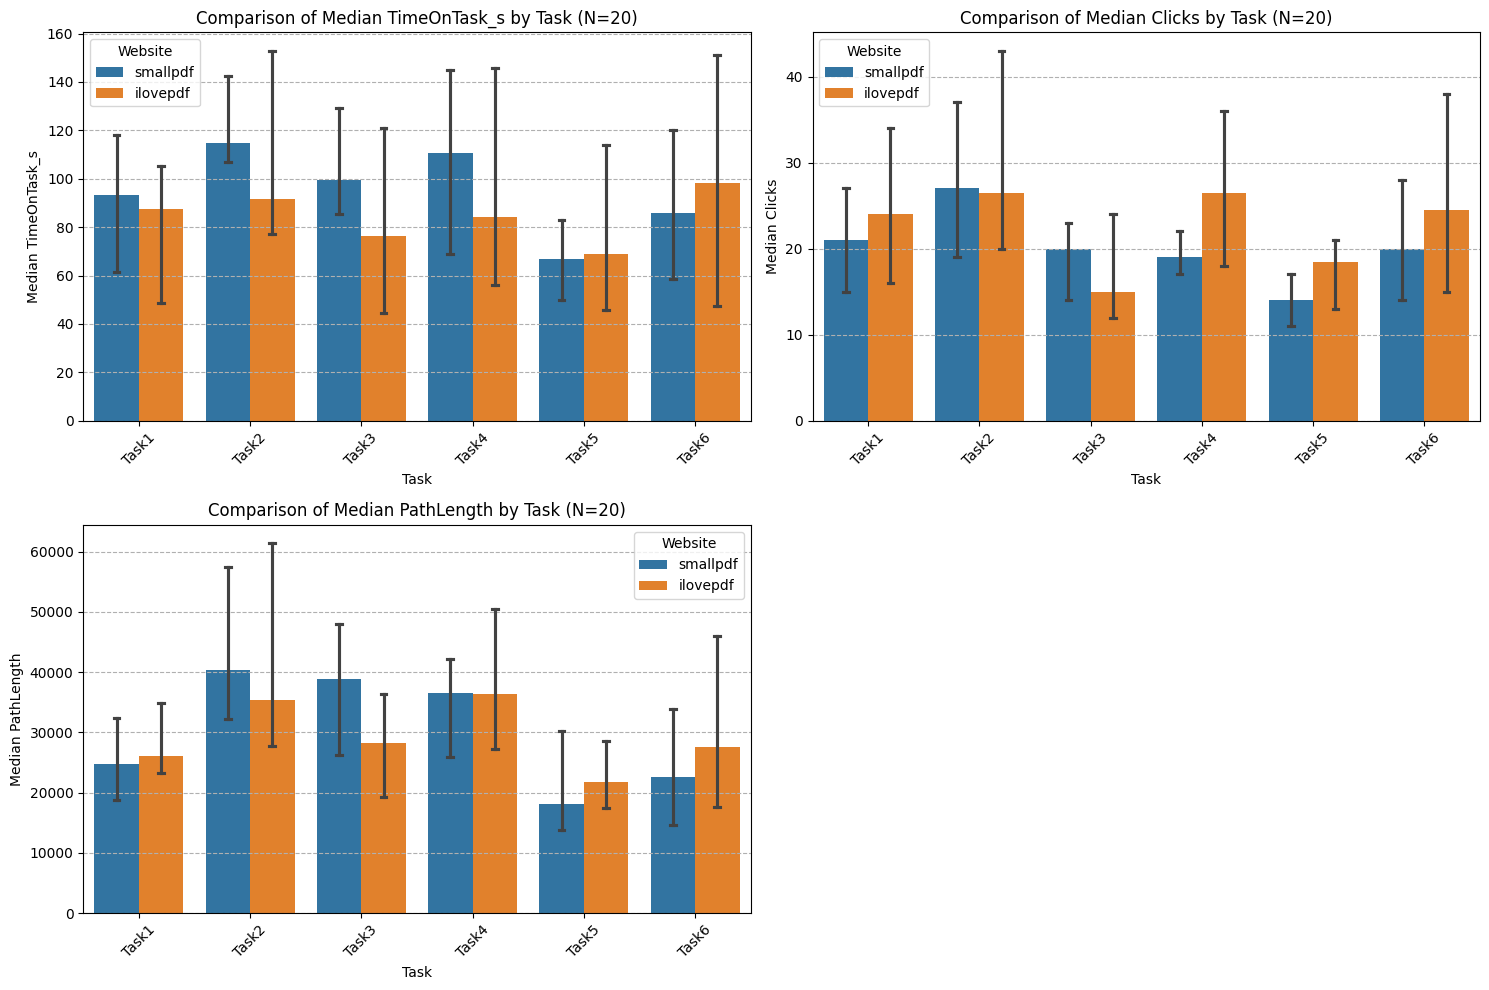


--- Analysis Complete ---


In [7]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load and Prepare Data ---
try:
    # Assuming the file is in the same directory as the script
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)

    # Convert Time to Seconds
    df["TimeOnTask_s"] = df["TrialDurationms"] / 1000

    # Rename columns
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MousePathlengthpx": "PathLength",
            "TrialName": "Task",
        },
        inplace=True,
    )

    # Map Site codes to names
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # Define metrics and tasks
    metrics = ["TimeOnTask_s", "Clicks", "PathLength"]
    tasks = sorted(df_filtered["Task"].unique())
    subjects = sorted(df_filtered["SubjectId"].unique())  # Get unique subjects

    print(f"Data loaded. N = {len(subjects)} participants. with {subjects}")
    N = len(subjects)

    print(f"Data loaded. N = {N} participants identified: {subjects}")
    print(f"Tasks to analyze: {tasks}")
    print(f"Metrics to analyze: {metrics}")

    # Verify data structure before pairing attempt
    print("\nSample data before pairing:")
    print(df_filtered[["SubjectId", "Task", "SiteName", "TimeOnTask_s"]].head())
    print(f"\nValue counts for SiteName:\n{df_filtered['SiteName'].value_counts()}")


except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Statistical Analysis (Paired - Manual Pairing) ---
results = {}
paired_analysis_data = []  # To store data used in analysis

for task in tasks:
    results[task] = {}
    print(f"\n--- Analyzing Task: {task} ---")

    for metric in metrics:
        results[task][metric] = {}
        list1_ilovepdf = []
        list2_smallpdf = []
        valid_subjects_in_task_metric = 0

        for subject in subjects:
            # Get data for this subject and task
            subject_task_data = df_filtered[
                (df_filtered["SubjectId"] == subject) & (df_filtered["Task"] == task)
            ]

            # Find the value for ilovepdf and smallpdf
            val1 = subject_task_data.loc[
                subject_task_data["SiteName"] == "ilovepdf", metric
            ].values
            val2 = subject_task_data.loc[
                subject_task_data["SiteName"] == "smallpdf", metric
            ].values

            # Ensure BOTH values exist for this subject-task-metric pair
            if len(val1) == 1 and len(val2) == 1:
                # Check for NaN values just in case (though user stated none exist)
                if not pd.isna(val1[0]) and not pd.isna(val2[0]):
                    list1_ilovepdf.append(val1[0])
                    list2_smallpdf.append(val2[0])
                    valid_subjects_in_task_metric += 1
                    # Store data used for potential later use/verification
                    paired_analysis_data.append(
                        {
                            "SubjectId": subject,
                            "Task": task,
                            "Metric": metric,
                            "ilovepdf": val1[0],
                            "smallpdf": val2[0],
                        }
                    )

        print(f"\nMetric: {metric}")
        print(
            f" Found valid paired data for N = {valid_subjects_in_task_metric} participants in this task/metric."
        )

        # Convert lists to numpy arrays for analysis
        data1_paired = np.array(list1_ilovepdf)
        data2_paired = np.array(list2_smallpdf)

        # Check if enough paired data exists
        if valid_subjects_in_task_metric < 1:  # Need at least 1 pair
            print(" No valid paired data found.")
            results[task][metric]["stat_test"] = "No valid paired data"
            continue

        # Descriptive Statistics (for the actual paired samples used)
        desc1_mean = np.mean(data1_paired)
        desc1_median = np.median(data1_paired)
        desc1_std = np.std(data1_paired)
        desc2_mean = np.mean(data2_paired)
        desc2_median = np.median(data2_paired)
        desc2_std = np.std(data2_paired)

        results[task][metric]["desc_ilovepdf_mean"] = desc1_mean
        results[task][metric]["median_ilovepdf"] = desc1_median
        results[task][metric]["desc_smallpdf_mean"] = desc2_mean
        results[task][metric]["median_smallpdf"] = desc2_median

        print(
            f" ilovepdf (Paired): Mean={desc1_mean:.2f}, Median={desc1_median:.2f}, StdDev={desc1_std:.2f}, N={valid_subjects_in_task_metric}"
        )
        print(
            f" smallpdf (Paired): Mean={desc2_mean:.2f}, Median={desc2_median:.2f}, StdDev={desc2_std:.2f}, N={valid_subjects_in_task_metric}"
        )

        # Inferential Statistics (Wilcoxon Signed-Rank test)
        if (
            valid_subjects_in_task_metric < 5
        ):  # Minimum recommended N for Wilcoxon varies, 5 is conservative
            print(
                f" Not enough paired data (N={valid_subjects_in_task_metric}) for robust Wilcoxon test."
            )
            results[task][metric]["stat_test"] = "Not enough pairs for Wilcoxon"
            continue

        try:
            # Calculate differences for Wilcoxon
            diff = data1_paired - data2_paired
            # Perform test only if there are non-zero differences
            if np.all(diff == 0):
                print(" All differences are zero. Cannot perform Wilcoxon test.")
                results[task][metric]["stat_test"] = (
                    "Wilcoxon Error: All differences zero"
                )
                continue

            stat, p_value = wilcoxon(diff)
            results[task][metric]["stat_test"] = "Wilcoxon Signed-Rank"
            results[task][metric]["statistic"] = stat
            results[task][metric]["p_value"] = p_value
            print(f" Wilcoxon Signed-Rank Test: W={stat:.2f}, p={p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
                if desc1_median > desc2_median:
                    print(
                        "  Interpretation: ilovepdf has significantly higher median value."
                    )
                elif desc2_median > desc1_median:
                    print(
                        "  Interpretation: smallpdf has significantly higher median value."
                    )
                else:
                    print(
                        "  Interpretation: Medians are equal, but distribution differs significantly."
                    )
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")

        except ValueError as ve:
            print(f" Could not perform Wilcoxon test: {ve}")
            results[task][metric]["stat_test"] = f"Wilcoxon Error: {ve}"

# Create DataFrame from the analysis data for verification
analysis_df = pd.DataFrame(paired_analysis_data)
# print("\nSample of data used in paired analysis:")
# print(analysis_df.head())


# --- 3. Visualization (Using original long-format data 'df_filtered') ---
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
axes_flat = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes_flat[i]
    # Ensure plotting uses the original filtered data which has SubjectId for correct CI calculation
    plot_data = df_filtered.dropna(subset=[metric])

    sns.barplot(
        data=plot_data,
        x="Task",
        y=metric,
        hue="SiteName",
        estimator=np.median,  # Show median
        errorbar=("ci", 95),  # Show 95% CI (using bootstrap respecting subjects)
        capsize=0.1,
        ax=ax,
        order=tasks,
    )

    ax.set_title(f"Comparison of Median {metric} by Task (N={N})")
    ax.set_ylabel(f"Median {metric}")
    ax.set_xlabel("Task")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Website")
    ax.grid(axis="y", linestyle="--")

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

print("\n--- Analysis Complete ---")
# You can access detailed results from the 'results' dictionary if needed.
# Example: print(results['Task1']['TimeOnTask_s']['p_value'])


Data loaded. N = 10 participants identified by name: ['big', 'cat', 'chacha', 'fon', 'kapook', 'mink', 'moew', 'muz', 'nai', 'palm']
Tasks to analyze: ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6']
Metrics to analyze: ['TimeOnTask_s', 'Clicks', 'PathLength']

--- Analyzing Task: Task1 ---

Metric: TimeOnTask_s
 Found valid paired data for N = 9 participants in this task/metric.
 ilovepdf (Paired): Mean=84.99, Median=86.20, StdDev=47.07, N=9
 smallpdf (Paired): Mean=84.74, Median=85.85, StdDev=30.85, N=9
 Wilcoxon Signed-Rank Test: W=22.00, p=1.0000
  Result: No statistically significant difference (p >= 0.05)

Metric: Clicks
 Found valid paired data for N = 9 participants in this task/metric.
 ilovepdf (Paired): Mean=23.56, Median=22.00, StdDev=9.08, N=9
 smallpdf (Paired): Mean=18.78, Median=20.00, StdDev=5.49, N=9
 Wilcoxon Signed-Rank Test: W=11.00, p=0.3264
  Result: No statistically significant difference (p >= 0.05)

Metric: PathLength
 Found valid paired data for N = 9 p

d:\Users\User\anaconda3\envs\thesis-may\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


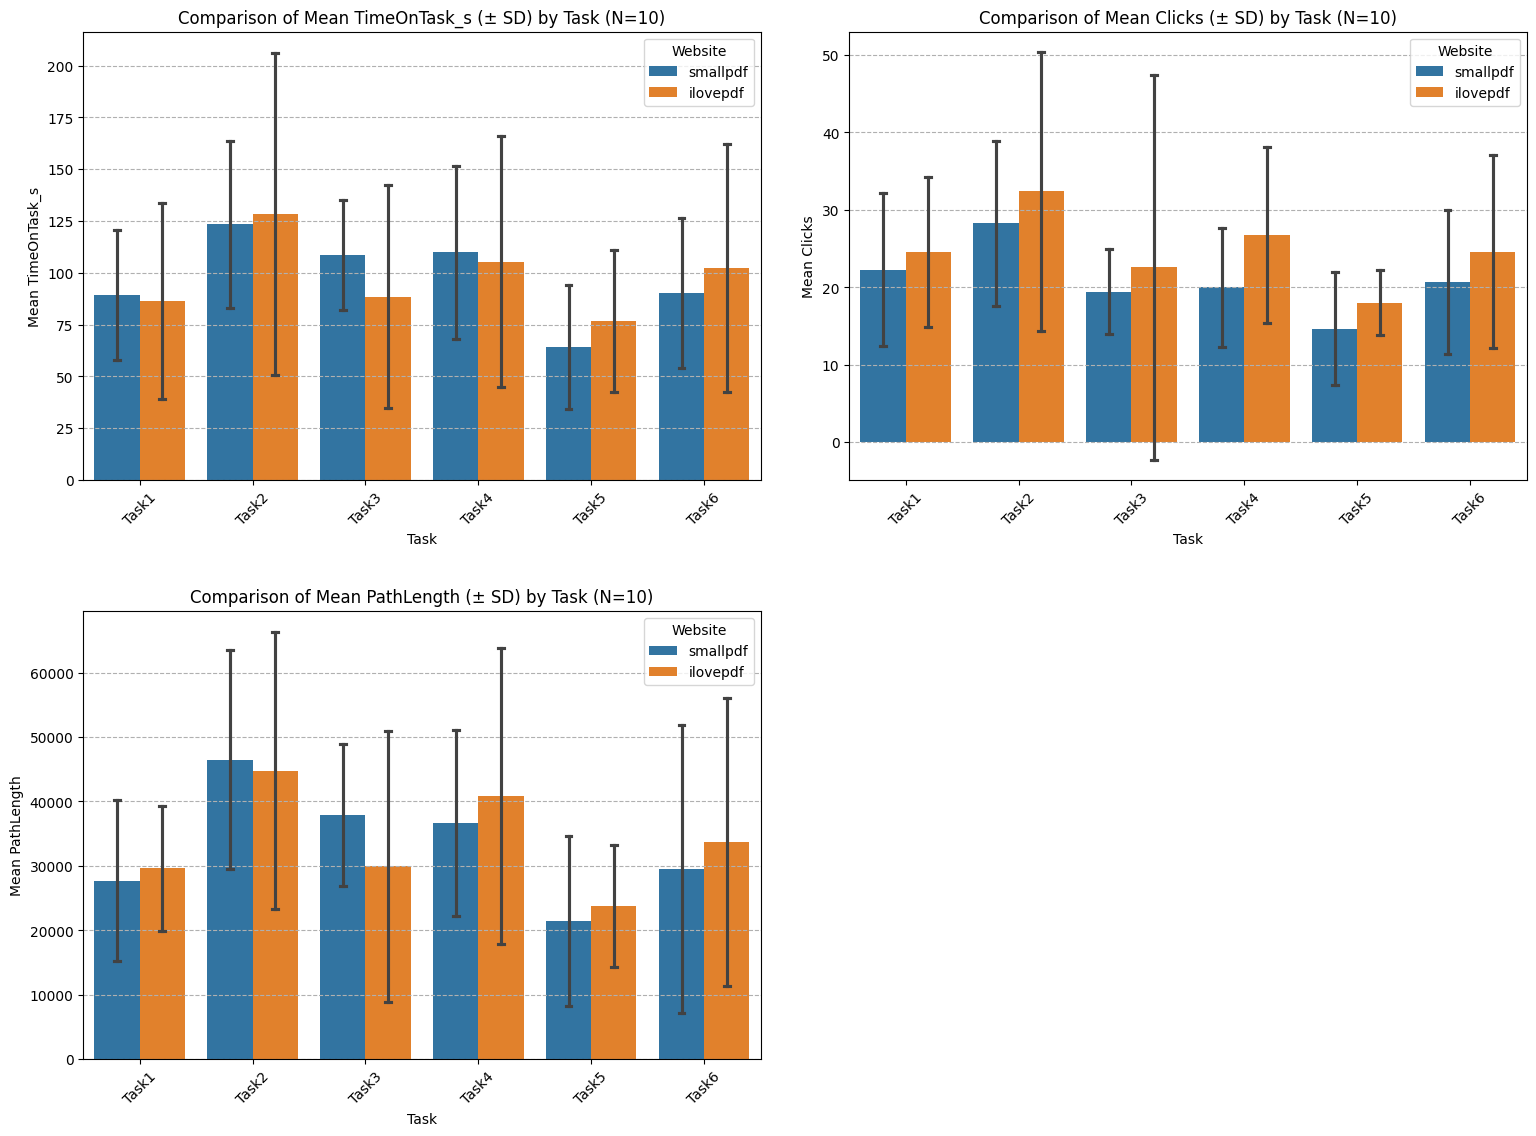


--- Plotting Complete ---

--- Descriptive Statistics Summary ---
               TimeOnTask_s                               Clicks         \
                       mean    std  median count      sum   mean    std   
Task  SiteName                                                            
Task1 ilovepdf        86.52  47.32   87.55    10   865.25  24.60   9.66   
      smallpdf        89.35  31.21   93.20    11   982.85  22.27   9.87   
Task2 ilovepdf       128.30  77.82   91.42    10  1282.95  32.40  17.98   
      smallpdf       123.40  40.12  114.60    11  1357.40  28.27  10.64   
Task3 ilovepdf        88.51  53.77   76.15    10   885.05  22.60  24.85   
      smallpdf       108.47  26.48   99.50    11  1193.15  19.45   5.48   
Task4 ilovepdf       105.39  60.54   84.12    10  1053.90  26.80  11.35   
      smallpdf       110.07  41.74  110.80    11  1210.75  20.00   7.66   
Task5 ilovepdf        76.77  34.12   68.97    10   767.70  18.00   4.19   
      smallpdf        64.17  29.9

In [9]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Load and Prepare Data ---
try:
    # Assuming the file is in the same directory as the script
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names (ensure consistent naming)
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)
    # --- > Check the exact cleaned name for 'Subject name' <---
    # It's likely 'Subjectname' after cleaning, adjust if needed
    subject_column_name = "Subjectname"  # Adjust this if cleaning resulted differently

    if subject_column_name not in df.columns:
        print(f"Error: Column '{subject_column_name}' not found after cleaning.")
        print(f"Available columns: {df.columns.tolist()}")
        exit()

    # Convert Time to Seconds
    df["TimeOnTask_s"] = df["TrialDurationms"] / 1000

    # Rename columns if needed (Clicks, PathLength, Task should be correct)
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MousePathlengthpx": "PathLength",
            "TrialName": "Task",
        },
        inplace=True,
        errors="ignore",
    )  # Use errors='ignore' if renaming might fail

    # Map Site codes to names
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # --- > Use Subject name to identify unique participants <---
    subjects = sorted(df_filtered[subject_column_name].unique())
    N = len(subjects)

    # Define metrics and tasks
    metrics = ["TimeOnTask_s", "Clicks", "PathLength"]
    tasks = sorted(df_filtered["Task"].unique())

    print(f"Data loaded. N = {N} participants identified by name: {subjects}")
    print(f"Tasks to analyze: {tasks}")
    print(f"Metrics to analyze: {metrics}")


except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Statistical Analysis (Paired - Manual Pairing using Subject Name) ---
results = {}
paired_analysis_data = []

for task in tasks:
    results[task] = {}
    print(f"\n--- Analyzing Task: {task} ---")

    for metric in metrics:
        results[task][metric] = {}
        list1_ilovepdf = []
        list2_smallpdf = []
        valid_subjects_in_task_metric = 0

        # --- > Iterate through unique Subject names <---
        for subject_name in subjects:
            # Get data for this subject name and task
            # --- > Filter using the subject name column <---
            subject_task_data = df_filtered[
                (df_filtered[subject_column_name] == subject_name)
                & (df_filtered["Task"] == task)
            ]

            # Find the value for ilovepdf and smallpdf
            val1 = subject_task_data.loc[
                subject_task_data["SiteName"] == "ilovepdf", metric
            ].values
            val2 = subject_task_data.loc[
                subject_task_data["SiteName"] == "smallpdf", metric
            ].values

            # Ensure BOTH values exist for this subject-task-metric pair
            if len(val1) == 1 and len(val2) == 1:
                if not pd.isna(val1[0]) and not pd.isna(val2[0]):
                    list1_ilovepdf.append(val1[0])
                    list2_smallpdf.append(val2[0])
                    valid_subjects_in_task_metric += 1
                    paired_analysis_data.append(
                        {
                            "SubjectName": subject_name,  # Use SubjectName here
                            "Task": task,
                            "Metric": metric,
                            "ilovepdf": val1[0],
                            "smallpdf": val2[0],
                        }
                    )

        print(f"\nMetric: {metric}")
        print(
            f" Found valid paired data for N = {valid_subjects_in_task_metric} participants in this task/metric."
        )

        data1_paired = np.array(list1_ilovepdf)
        data2_paired = np.array(list2_smallpdf)

        if valid_subjects_in_task_metric < 1:
            print(" No valid paired data found.")
            results[task][metric]["stat_test"] = "No valid paired data"
            continue

        # Descriptive Statistics
        desc1_mean = np.mean(data1_paired)
        desc1_median = np.median(data1_paired)
        desc1_std = np.std(data1_paired)
        desc2_mean = np.mean(data2_paired)
        desc2_median = np.median(data2_paired)
        desc2_std = np.std(data2_paired)

        results[task][metric]["desc_ilovepdf_mean"] = desc1_mean
        results[task][metric]["median_ilovepdf"] = desc1_median
        results[task][metric]["desc_smallpdf_mean"] = desc2_mean
        results[task][metric]["median_smallpdf"] = desc2_median

        print(
            f" ilovepdf (Paired): Mean={desc1_mean:.2f}, Median={desc1_median:.2f}, StdDev={desc1_std:.2f}, N={valid_subjects_in_task_metric}"
        )
        print(
            f" smallpdf (Paired): Mean={desc2_mean:.2f}, Median={desc2_median:.2f}, StdDev={desc2_std:.2f}, N={valid_subjects_in_task_metric}"
        )

        # Inferential Statistics (Wilcoxon Signed-Rank test)
        if valid_subjects_in_task_metric < 5:
            print(
                f" Not enough paired data (N={valid_subjects_in_task_metric}) for robust Wilcoxon test."
            )
            results[task][metric]["stat_test"] = "Not enough pairs for Wilcoxon"
            continue

        try:
            diff = data1_paired - data2_paired
            if np.all(diff == 0):
                print(" All differences are zero. Cannot perform Wilcoxon test.")
                results[task][metric]["stat_test"] = (
                    "Wilcoxon Error: All differences zero"
                )
                continue

            stat, p_value = wilcoxon(diff)
            results[task][metric]["stat_test"] = "Wilcoxon Signed-Rank"
            results[task][metric]["statistic"] = stat
            results[task][metric]["p_value"] = p_value
            print(f" Wilcoxon Signed-Rank Test: W={stat:.2f}, p={p_value:.4f}")
            # ... (Interpretation logic remains the same) ...
            if p_value < 0.05:
                print("  Result: Statistically significant difference (p < 0.05)")
                if desc1_median > desc2_median:
                    print(
                        "  Interpretation: ilovepdf has significantly higher median value."
                    )
                elif desc2_median > desc1_median:
                    print(
                        "  Interpretation: smallpdf has significantly higher median value."
                    )
                else:
                    print(
                        "  Interpretation: Medians are equal, but distribution differs significantly."
                    )
            else:
                print("  Result: No statistically significant difference (p >= 0.05)")

        except ValueError as ve:
            print(f" Could not perform Wilcoxon test: {ve}")
            results[task][metric]["stat_test"] = f"Wilcoxon Error: {ve}"


# --- 3. Visualization (Descriptive: Mean +/- SD) ---
print("\nGenerating descriptive statistics plots (Mean +/- SD)...")

n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), squeeze=False)
axes_flat = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes_flat[i]
    plot_data = df_filtered.dropna(subset=[metric])

    sns.barplot(
        data=plot_data,
        x="Task",
        y=metric,
        hue="SiteName",
        estimator=np.mean,
        errorbar="sd",
        capsize=0.1,
        ax=ax,
        order=tasks,
    )

    ax.set_title(f"Comparison of Mean {metric} (± SD) by Task (N={N})")
    ax.set_ylabel(f"Mean {metric}")
    ax.set_xlabel("Task")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Website")
    ax.grid(axis="y", linestyle="--")

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout(pad=3.0)
plt.show()

print("\n--- Plotting Complete ---")

# --- 4. Optional: Print Descriptive Table ---
print("\n--- Descriptive Statistics Summary ---")
# Calculate descriptive stats grouped by Task and SiteName
descriptive_summary = (
    df_filtered.groupby(["Task", "SiteName"])[metrics]
    .agg(["mean", "std", "median", "count", "sum"])
    .round(2)
)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(descriptive_summary)


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import skew, mode as scipy_mode

# --- 1. Load and Prepare Data ---
try:
    file_path = "export_ogama_csv_fitlered_3.csv"
    df = pd.read_csv(file_path)

    # Clean column names
    df.columns = df.columns.str.strip().str.replace("[:\s\(\)/]", "", regex=True)
    subject_column_name = "Subjectname"  # Adjust if needed

    if subject_column_name not in df.columns:
        print(f"Error: Column '{subject_column_name}' not found after cleaning.")
        print(f"Available columns: {df.columns.tolist()}")
        exit()

    # Convert Time to Seconds (if needed for other metrics)
    # df['TimeOnTask_s'] = df['TrialDurationms'] / 1000

    # Rename relevant metrics columns
    df.rename(
        columns={
            "MouseLeftClickscount": "Clicks",
            "MouseLeftClickscounts": "Clicks_per_sec",  # Assuming this is the cleaned name for Clicks (count/s)
            "TrialName": "Task",
        },
        inplace=True,
        errors="ignore",
    )

    # Map Site codes to names
    site_map = {"s": "smallpdf", "i": "ilovepdf"}
    df["SiteName"] = df["Site"].map(site_map)

    # Filter out Task0
    df_filtered = df[df["Task"] != "Task0"].copy()

    # Define metrics for the table
    metrics_to_analyze = [
        "Clicks",
        "Clicks_per_sec",
    ]  # Focus on metrics shown in the example table

    print("Data loaded and prepared.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading/preparation: {e}")
    exit()

# --- 2. Define Custom Aggregation Functions ---


# Function to calculate Standard Error of the Mean
def se_mean(x):
    if len(x) < 1:
        return np.nan
    return x.std() / np.sqrt(len(x))


# Function to get the first mode
def first_mode(x):
    # Use scipy's mode which handles NaNs better and returns mode and count
    res = scipy_mode(x.dropna())
    if res.count.size > 0 and res.count[0] > 0:  # Check if mode exists
        # Check if the mode value itself is NaN (can happen with mixed types or all NaNs)
        if pd.isna(res.mode[0]):
            return np.nan  # Or some other placeholder like 'N/A'
        return res.mode[0]
    else:
        return np.nan  # Or 'N/A' if no mode found


# Function to calculate Standard Error of Skewness (use with caution on non-normal data)
def se_skewness(x):
    n = len(x.dropna())
    if n < 3:  # Need at least 3 data points
        return np.nan
    # Formula for SE Skewness under normality assumption
    se = np.sqrt((6 * n * (n - 1)) / ((n - 2) * (n + 1) * (n + 3)))
    return se


# Function to calculate Range
def data_range(x):
    if len(x.dropna()) < 1:
        return np.nan
    return x.max() - x.min()


# --- 3. Calculate Descriptive Statistics ---

# Group by Task and SiteName
grouped = df_filtered.groupby(["Task", "SiteName"])

# Define aggregations
agg_funcs = {
    "N": "count",
    "Mean": "mean",
    "SE Mean": se_mean,
    "Median": "median",
    "Mode": first_mode,
    "SD": "std",
    "Variance": "var",
    "Range": data_range,
    "Minimum": "min",
    "Maximum": "max",
    "Skewness": "skew",
    "SE Skewness": se_skewness,
}

# Calculate stats for the selected metrics
descriptive_stats = grouped[metrics_to_analyze].agg(agg_funcs)

# --- 4. Calculate 'Missing' ---
# Find the max N for each Task to determine the expected count
max_n_per_task = grouped.size().unstack().max(axis=1)


# Function to calculate missing based on max N for the task
def calculate_missing(row):
    task = row.name[0]  # Get Task from multi-index
    max_n = max_n_per_task.get(task, 0)
    return max_n - row[("N")]  # Access N using tuple for multi-index column


# Apply the function - Need to handle multi-index columns correctly
# We'll calculate N first, then merge max_n, then calculate missing
n_counts = grouped[metrics_to_analyze[0]].agg({"N": "count"})  # Get N using one metric
n_counts = n_counts.reset_index()
n_counts["MaxN_in_Task"] = n_counts["Task"].map(max_n_per_task)
n_counts["Missing"] = n_counts["MaxN_in_Task"] - n_counts["N"]
n_counts = n_counts.set_index(["Task", "SiteName"])["Missing"]

# Add Missing column to the main stats dataframe
# Need to add it for each metric's block of columns
for metric in metrics_to_analyze:
    # Create a temporary series with the correct multi-index
    missing_col = pd.Series(
        n_counts.values, index=descriptive_stats[metric].index, name="Missing"
    )
    # Insert the 'Missing' column after 'N'
    descriptive_stats.insert(
        loc=descriptive_stats.columns.get_loc((metric, "N")) + 1,
        column=(metric, "Missing"),
        value=missing_col,
    )


# --- 5. Format and Display Table ---

# Optional: Round the results
descriptive_stats = descriptive_stats.round(4)

# Rename columns slightly for better display if needed (optional)
# descriptive_stats.columns.set_levels(['Metric Name 1', 'Metric Name 2'], level=0, inplace=True)

# Print the resulting table
print("--- Descriptive Statistics Table ---")
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.width", 1000
):
    print(descriptive_stats)

# Example of accessing a specific value:
# print("\nExample Access:")
# try:
#     task1_s_clicks_mean = descriptive_stats.loc[('Task1', 'smallpdf'), ('Clicks', 'Mean')]
#     print(f"Task1, smallpdf, Clicks Mean: {task1_s_clicks_mean}")
# except KeyError:
#     print("Could not access example value.")


Data loaded and prepared.


KeyError: "Column(s) ['Maximum', 'Mean', 'Median', 'Minimum', 'Mode', 'N', 'Range', 'SD', 'SE Mean', 'SE Skewness', 'Skewness', 'Variance'] do not exist"